In [1]:
%cd ../..

/home/zilian/projects/bachelorproef


/home/zilian/projects/bachelorproef/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
import numpy as np
from src.api.db import engine
from sqlalchemy.orm import Session
from src.api.models.db import CalibrationRecording
import matplotlib.pyplot as plt
import src.api.controllers.generate_embeddings as generate_embeddings
from pathlib import Path
from src.api.models.db import SimRoomClass

# Creating Embeddings from Annotations for each Class:

Some important notes here:

We should probably be setting a minimum sample count per class when labeling. 
Additionally, we should set an upper bound on the number of samples per class added to the database, based on the lowest amount of samples available for the classes.

Question: Should we do data augmentation as well?

The following are some interesting parameters to experiment with based on experimentation on real-world data:
1. Sample count per class
2. Data augmentation (and which kinds?)
3. Same number of samples per class or not?
4. ?

In [15]:
class_id_to_name = SimRoomClass.get_id_to_name_map()

In [18]:
X = []
Y = []

with Session(engine) as session:    
    calibration_recording: CalibrationRecording = session.query(CalibrationRecording).filter(CalibrationRecording.id == 1).first()
    if calibration_recording is None:
        raise ValueError("Calibration recording not found")

    labeling_result_paths = calibration_recording.labeling_result_paths

    # Load all the results
    for result_path in labeling_result_paths:
        for result in result_path.iterdir():
            file = np.load(result)
            X.append(file["roi"])
            Y.append(file["class_id"])

Y = np.array(Y)
classes, counts = np.unique(Y, return_counts=True)
min_samples_per_class = min(counts)

print(f"Found {len(X)} samples")
for i in range(len(classes)):
    print(f"{class_id_to_name[classes[i]]}: {counts[i]} samples")

Found 5663 samples
picture 1: 370 samples
round candle: 352 samples
hand drawing: 326 samples
picture 2: 364 samples
guitar 1: 554 samples
candle bottle: 409 samples
book: 509 samples
salt lamp: 680 samples
pillow: 504 samples
guitar 2: 566 samples
candle: 488 samples
laptop: 541 samples


In [10]:
selected_indices = []
for cls in np.unique(Y):
    cls_indices = np.where(Y == cls)[0]
    # Randomly choose N indices if more than N available, otherwise take all indices
    if len(cls_indices) > min_samples_per_class:
        chosen = np.random.choice(cls_indices, size=min_samples_per_class, replace=False)
    else:
        chosen = cls_indices
    selected_indices.extend(chosen)

selected_indices = np.array(selected_indices)
selected_X = [X[i] for i in selected_indices]
selected_Y = Y[selected_indices]

print(f"Selected {len(selected_X)} ROIs total, balanced across classes.")


Selected 3912 ROIs total, balanced across classes.


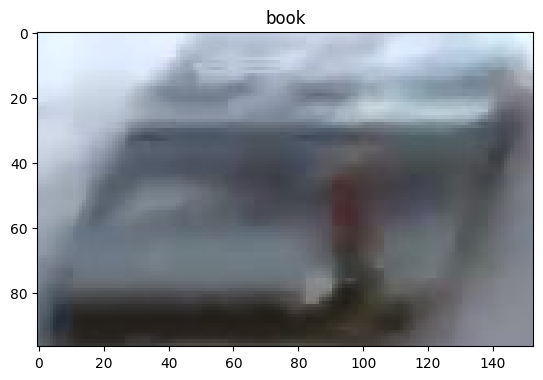

In [19]:
sample_idx = 0
roi = X[sample_idx]
plt.title(f"{class_id_to_name[Y[sample_idx]]}")
plt.imshow(roi)
plt.show()

In [20]:
dinov2 = generate_embeddings.load_model()
index = generate_embeddings.create_index()

for embeddings, batch_start, batch_end in generate_embeddings.get_embeddings(dinov2, selected_X, log_performance=True):
    sample_class_ids = np.array(selected_Y[batch_start:batch_end])
    generate_embeddings.add_embeddings_to_index(index, embeddings, sample_class_ids)

generate_embeddings.write_index(index, Path("notebooks/analysis-pipeline/data/embeddings.index"))

Generated 3912 embeddings at 581.90 samples per second
